In [6]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider
from matplotlib import colors
from matplotlib.colors import ListedColormap
from tqdm import tqdm

## Load data

In [7]:
%cd /home/plunder/.julia/dev/MechanochemicalPatterns/input/cell_tracking

/home/plunder/.julia/dev/MechanochemicalPatterns/input/cell_tracking


In [66]:
experiment = "split_20231212"
data = "FWF006"
cell_type = "Proximal"

In [67]:
def open_df(data,experiment=experiment):
    df = pd.read_csv(experiment + "/Automation_out/"+data+"_spots.csv", skiprows = [1,2,3], header = 0)
    return df

In [68]:
def get_filtered_ids_len(df,N=100):
    ids, len_ids = np.unique(df["TRACK_ID"].to_numpy(),return_counts=True)
    keep = np.ones(len(ids),dtype=bool)
    for i in range(len(ids)):
        keep[i] = (len_ids[i]>=N) and (len(np.unique(df[df["TRACK_ID"]==ids[i]]["FRAME"].to_numpy()))>=N)
    return ids[keep], len_ids[keep]

def traj(id,df): 
    # frames = np.sort(df[df["TRACK_ID"]==id]["FRAME"].to_numpy())
    frames = np.unique(df[df["TRACK_ID"]==id]["FRAME"].to_numpy())
    T = len(frames)
    pos = np.zeros((T,3))
    intensity = np.zeros(T)
    df_id = df[df["TRACK_ID"]==id]
    for t in range(T):
        pos[t,0] = df_id[df_id["FRAME"]==frames[t]]["POSITION_X"].values[0]
        pos[t,1] = df_id[df_id["FRAME"]==frames[t]]["POSITION_Y"].values[0]
        pos[t,2] = df_id[df_id["FRAME"]==frames[t]]["POSITION_Z"].values[0]
        intensity[t] = df_id[df_id["FRAME"]==frames[t]]["TOTAL_INTENSITY_CH1"].values[0]
    return frames, pos, intensity

def df_to_traj(data,N=100):
    df = open_df(data)
    ids, len_ids = get_filtered_ids_len(df,N=N)
    trajs = []
    for id in tqdm(ids):
        trajs.append(traj(id,df))
    return trajs

def construct_cmap(cell_type):
    if cell_type=="Proximal":
        # cmap_base = pl.cm.Purples
        cmap_base = colors.LinearSegmentedColormap.from_list("magenta", ["m","m"], N=1000)
    elif cell_type=="Distal":
        # cmap_base = pl.cm.Greens
        cmap_base = colors.LinearSegmentedColormap.from_list("magenta", ["g","g"], N=1000)
    else:
        cmap_base = plt.cm.Blues
    # Get the colormap colors
    cmap = cmap_base(np.arange(cmap_base.N))
    # Set alpha
    cmap[:,-1] = np.linspace(0, 1, cmap_base.N)**2
    # Create new colormap
    cmap = ListedColormap(cmap)
    return cmap

cmap = construct_cmap(cell_type)
    

In [69]:
trajs = df_to_traj(data + "_" + cell_type, N=50)

# if cell_type == "Proximal":
#     cmap = plt.cm.Purples(np.linspace(0.3,1,len(trajs)))
# elif cell_type=="Distal":
#     cmap = plt.cm.Greens(np.linspace(0.3,1,len(trajs)))
# else:
#     cmap = plt.cm.Blue(np.linspace(0.3,1,len(trajs)))



100%|██████████| 825/825 [00:33<00:00, 24.54it/s]


In [43]:
import os
import torch
import pickle 

def sample_grid(n, dim=2,dtype=torch.float32,device="cpu"):
    grid_points = torch.linspace(0,1,n,dtype=dtype,device=device)
    grid_points = torch.stack(
        torch.meshgrid((grid_points,) * dim, indexing="ij"), dim=-1
    )
    grid_points = grid_points.reshape(-1, dim)
    return grid_points

N = 512
y_grid = sample_grid(N)
R = 0.05

def neighbours_grid(i,y_grid,R):
    yi = y_grid[i,:].reshape((1,2))
    return (((yi - y_grid)**2).sum(1) <= R**2).float().squeeze()

def open_data(data_dir,N=512):
    T = len([name for name in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, name))])
    data = torch.zeros((N,N,T))
    for t in range(1,T+1):
        with open(data_dir + "data_" + str(t) + ".pkl", 'rb') as file:
            data[:,:,t-1] = pickle.load(file)
    return data

data_dir = experiment+"_" + data + "_smooth/"+cell_type+"/data/"
df = open_data(data_dir,N=N)

def smooth_max(data,y_grid,R):
    N = data.shape[0]
    T = data.shape[2]
    data_max = torch.max(data.reshape((N*N,T)),dim=0)
    ngh_max = neighbours_grid(data_max[1][-1].item(),y_grid,R).bool()
    smooth_max = data.reshape((N*N,T))[ngh_max,:].sum(0) * (1/N)**2
    return data_max[1][-1].item(), smooth_max

index, smax = smooth_max(df,y_grid,R)
max_x = y_grid[index,0].item() * 1300 
max_y = y_grid[index,1].item() * 1300

## Plot trajectory

### One individual trajectory

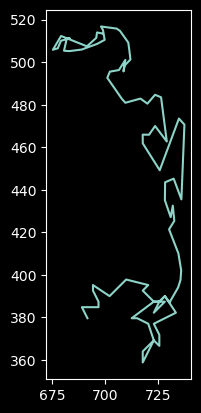

In [65]:
%matplotlib inline

fig, ax = plt.subplots()
n = 10
log_intensity = np.log10(trajs[n][2])
log_intensity -= log_intensity.min()
log_intensity *= 0.9/log_intensity.max()
log_intensity += 0.09
# ax.scatter(trajs_P[n][1][:,0],trajs_P[n][1][:,1],alpha=log_intensity)
ax.plot(trajs[n][1][:,0],trajs[n][1][:,1])
# ax.set_xlim(0,1300)
# ax.set_ylim(0,1300)
ax.set_aspect("equal")

### All trajectories

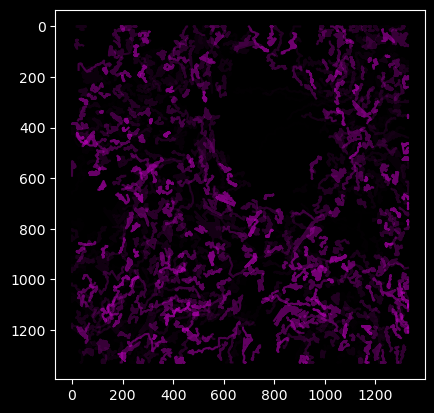

In [45]:
%matplotlib inline
plt.style.use('dark_background')

fig2d = plt.figure()
ax2d = fig2d.add_subplot()

clen = cmap.N
cind = 0
for tr in trajs:
    # ax2d.plot(tr[1][:,0],tr[1][:,1],'.',markersize=0.7,color=colors[cind%clen,:])
    ax2d.plot(tr[1][:,0],tr[1][:,1],color=cmap(cind/clen))
    cind += 1
ax2d.set_aspect("equal")
ax2d.invert_yaxis()

### Trajectories over time

In [70]:
def big_table_frame(trajs):
    N = len(trajs)
    T = max([max(traj[0]) for traj in trajs])
    big_table = -np.ones((T+1,N,3))
    for n in range(N):
        big_table[trajs[n][0],n,0] = trajs[n][1][:,0]
        big_table[trajs[n][0],n,1] = trajs[n][1][:,1]
        log_intensity = np.log10(trajs[n][2])
        log_intensity -= log_intensity.min()
        log_intensity *= 0.9/log_intensity.max()
        log_intensity += 0.09
        big_table[trajs[n][0],n,2] = log_intensity
    return big_table 

def plot_traj_frame(big_table,T=1,cmap=cmap):
    
    N = big_table.shape[1]
    fig = plt.figure()
    ax = fig.add_subplot()
    clen = cmap.N
    trajs_pl = []
    for n in range(N):
        trajs_pl.append(ax.plot(big_table[:(T+1),n,0],big_table[:(T+1),n,1],'.',markersize=4,color=cmap(0.1+0.9*n/clen))[0])
    scat_point = ax.scatter(big_table[T,:,0],big_table[T,:,1],s=6,c='c',zorder=2)

    ax.scatter([max_x],[max_y],s=6,c='r',zorder=2)
    
    ax.set_xlim(0,1300)
    ax.set_ylim(0,1300)
    ax.set_aspect("equal")
    ax.invert_yaxis()
    
    fig.subplots_adjust(left=0.25, bottom=0.25)

    axtime = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    frame_slider = Slider(
        ax=axtime,
        label='FRAME',
        valmin=1,
        valmax=big_table.shape[0]-1,
        valinit=1,
        valstep=1
    )
    
    def update(val):
        scat_point.set_offsets(np.c_[big_table[frame_slider.val,:,0],big_table[frame_slider.val,:,1]])
        for n in range(N):
            trajs_pl[n].set_xdata(big_table[:(frame_slider.val+1),n,0])
            trajs_pl[n].set_ydata(big_table[:(frame_slider.val+1),n,1])
            if big_table[frame_slider.val,n,0]<0:
                trajs_pl[n].set_alpha(0.0)
            else:
                trajs_pl[n].set_alpha(0.1+0.9*n/clen)
        fig.canvas.draw_idle()
    
    
    frame_slider.on_changed(update)
    
    return fig, ax

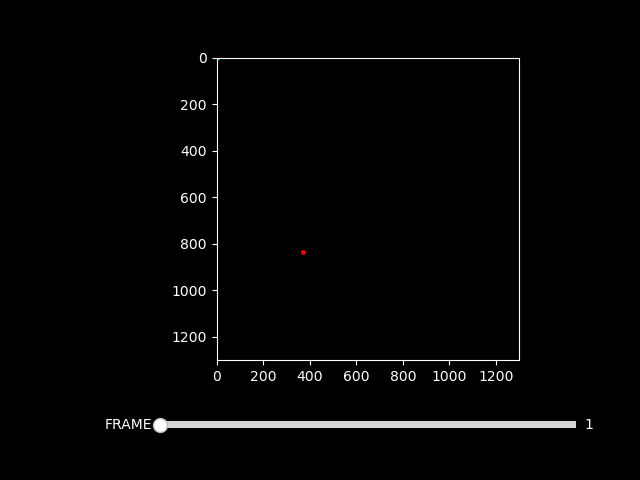

In [71]:
%matplotlib widget
plt.style.use('dark_background')
fig_traj_time, ax_traj_time = plot_traj_frame(big_table_frame(trajs),cmap=cmap)

In [73]:
big_table = big_table_frame(trajs)[100:,:,:]

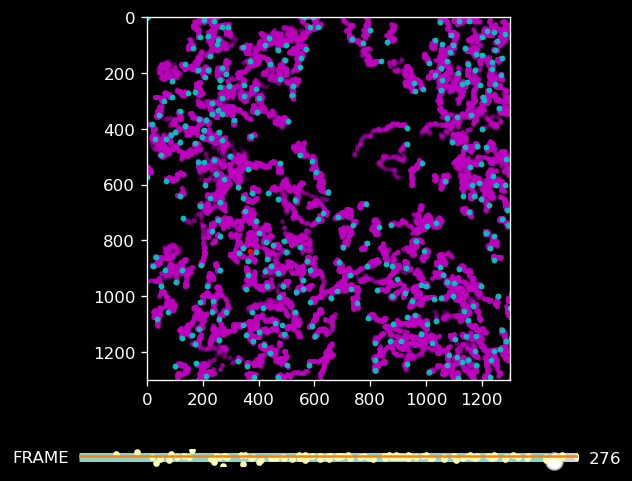

In [74]:
%matplotlib inline

max_x, max_y = 1100, 150

dist0 = []
dist1 = []
align = []
direct = []
msd2 = []
steps = []
max_np = np.array([max_x,max_y])
for n in range(big_table.shape[1]):
    traj = big_table[:,n,:]
    traj = traj[traj[:,0]>=0]
    if len(traj)>10:
        traj0 = traj[0,:2]
        traj1 = traj[-1,:2]
        dist0.append(math.sqrt((traj0[0].item() - max_x)**2 + (traj0[1].item() - max_y)**2))
        dist1.append(math.sqrt((traj1[0].item() - max_x)**2 + (traj1[1].item() - max_y)**2))
        u01 = (traj1 - traj0)/np.linalg.norm(traj1 - traj0)
        u0m = (max_np - traj0)/np.linalg.norm(max_np - traj0)
        align.append((u01*u0m).sum().item())
        u = traj[:,:2] - traj0.reshape((1,2))
        u01_p = np.array([-u01[1],u01[0]]).reshape((1,2))
        u0m_p = np.array([-u0m[1],u0m[0]]).reshape((1,2))
        direct.append(np.abs((u * u0m_p).sum(1)).mean())
        msd2.append((u*u).sum(1).mean())
        steps.append(traj.shape[0])

dist0 = np.array(dist0)
dist1 = np.array(dist1)
align = np.array(align)
direct = np.array(direct)
msd2 = np.array(msd2)

# plt.plot(dist0,(dist1 - dist0)/dist0,'.')
plt.plot(dist0, dist1 / dist0,'.')
plt.yscale('log')

# plt.hlines(y=0,xmin=0,xmax=1600,color="tab:orange")
plt.hlines(y=1,xmin=0,xmax=1300,color="tab:orange")
# plt.ylim(-1,1)

# plt.plot(dist0,align,'.')
# plt.plot(dist0,direct,'.')
# plt.plot(dist0,msd2,'.')
plt.show()

/home/plunder/mambaforge/envs/sisyphe/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/plunder/mambaforge/envs/sisyphe/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/plunder/mambaforge/envs/sisyphe/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/plunder/mambaforge/envs/sisyphe/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/plunder/mambaforge/envs/sisyphe/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


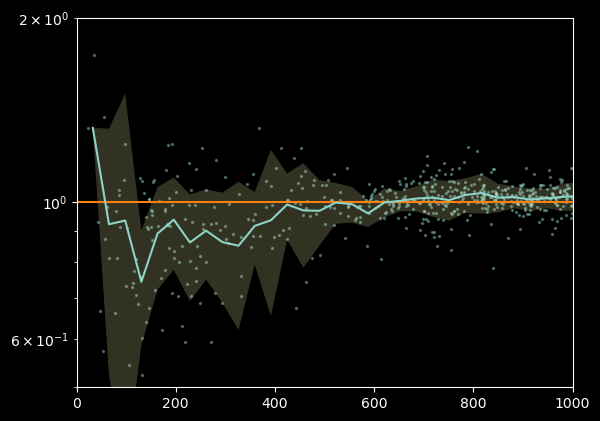

In [75]:
avg_dist_trend(dist0, dist1 / dist0, 50, hline = 1, log_scale = True)

In [57]:
def avg_dist_trend(dist0, data, nbins = 30, hline = 1, log_scale = False, x_lim = 1000):
    bins = np.linspace(0,1600,nbins)
    dist0_d = np.digitize(dist0,bins)

    mean_dist10 = [ np.mean(data[dist0_d==i]) for i in range(len(bins)) ]
    mean_dist10 = np.array(mean_dist10)

    std_dist10 = [ np.std(data[dist0_d==i]) for i in range(len(bins)) ]
    std_dist10 = np.array(std_dist10)


    bins = bins[~np.isnan(mean_dist10)]
    mean_dist10 = mean_dist10[~np.isnan(mean_dist10)]
    std_dist10 = std_dist10[~np.isnan(std_dist10)]

    plt.hlines(y=hline,xmin=0,xmax=1300,color="tab:orange")
    if log_scale:
        plt.yscale('log')
        plt.ylim(0.5,2)

    plt.xlim(0, x_lim)

    plt.scatter(dist0, data, s=2, alpha=0.4 - len(data)/10000 * 0.2)
    plt.plot(bins,mean_dist10)
    plt.fill_between(bins, mean_dist10-std_dist10, mean_dist10+std_dist10, alpha=0.2)

In [206]:
bins = np.linspace(0,1300,30)
dist0_d = np.digitize(dist0,bins)
type(dist0_d.dtype)

numpy.dtype[int64]

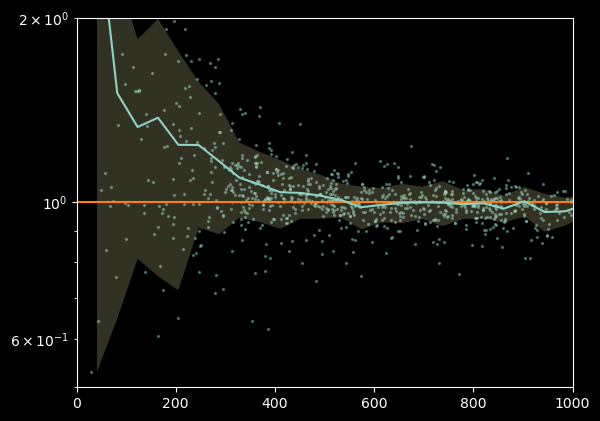

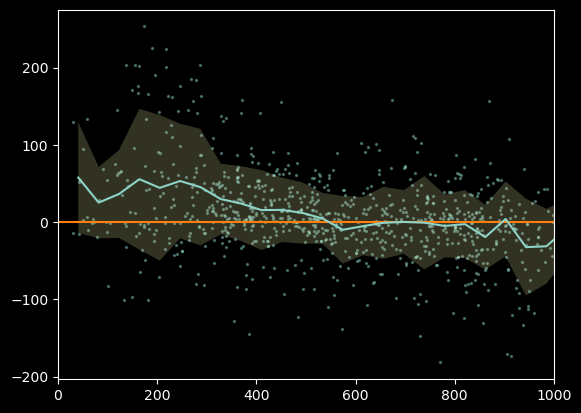

In [283]:
avg_dist_trend(dist0, (dist1 / dist0), 40, hline = 1, log_scale = True, x_lim = 1000)
plt.show()
avg_dist_trend(dist0, dist1 - dist0, 40, hline = 0, log_scale = False, x_lim = 1000)
plt.show()

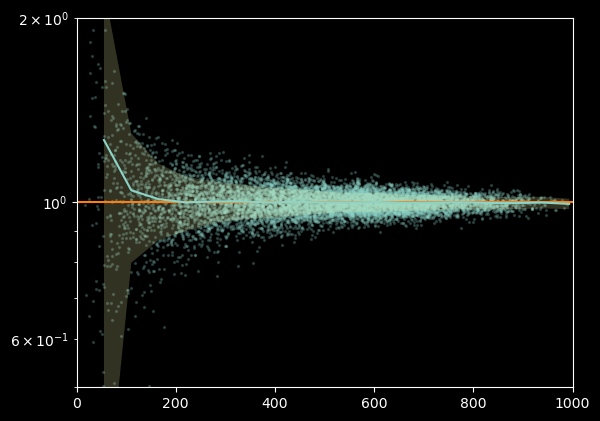

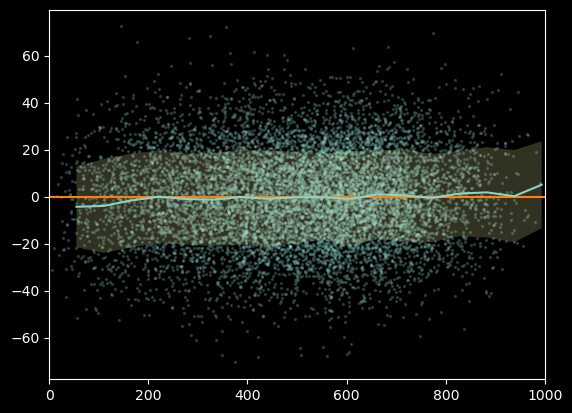

In [63]:
n = 10000

offset = 600
art_XY0 = np.random.uniform(-offset, 1300 - offset, size = (2,n))
art_XY1 = art_XY0 + np.random.normal(0, 20, size = (2,n))
np.clip(art_XY1, -offset, 1300 - offset, out = art_XY1)

art_dist0 = np.sqrt((art_XY0**2).sum(0))
art_dist1 = np.sqrt((art_XY1**2).sum(0))

avg_dist_trend(art_dist0, (art_dist1 / art_dist0), 30, hline = 1, log_scale = True)
plt.show()
avg_dist_trend(art_dist0, (art_dist0 - art_dist1), 30, hline = 0, log_scale = False)
plt.show()

In [43]:
np.random.uniform(0,1, (2,10))

array([[0.92430828, 0.33979764, 0.58835468, 0.69061693, 0.78580568,
        0.64635809, 0.57205723, 0.79661137, 0.81948629, 0.66259111],
       [0.30315422, 0.84072225, 0.0913738 , 0.81674786, 0.10612745,
        0.01624937, 0.87992147, 0.13434679, 0.01708958, 0.8588019 ]])

In [ ]:
# plt.ylim(0,20000)

# plt.ylim(-1000,2)
plt.show()

No such comm: beec23aa999b45aab6bbdeb47be4fc94


/var/folders/q_/7gz310cd4n1_v1xcnv2_qdbm0000gn/T/ipykernel_10798/1622910302.py:7: RuntimeWarning: invalid value encountered in scalar divide
  histo[k] = (in_log>0).sum()/len(in_log)


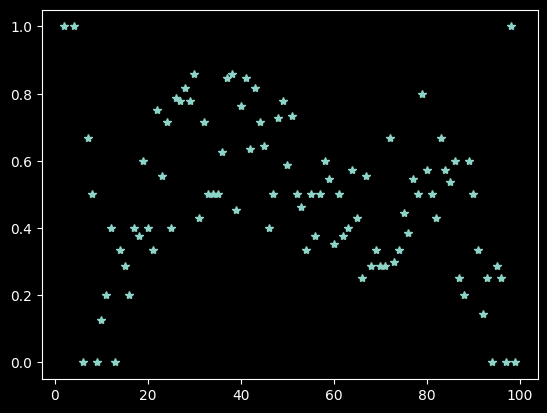

In [79]:
nb_bin = 100
bins = np.linspace(0,dist0.max(),nb_bin+1)
histo = np.zeros(nb_bin)
for k in range(nb_bin):
    in_bin = (dist0>=bins[k])&(dist0<bins[k+1])
    in_log = np.log10(dist1[in_bin]/dist0[in_bin])
    histo[k] = (in_log>0).sum()/len(in_log)
plt.plot(histo,'*')


(0.0, 20000.0)

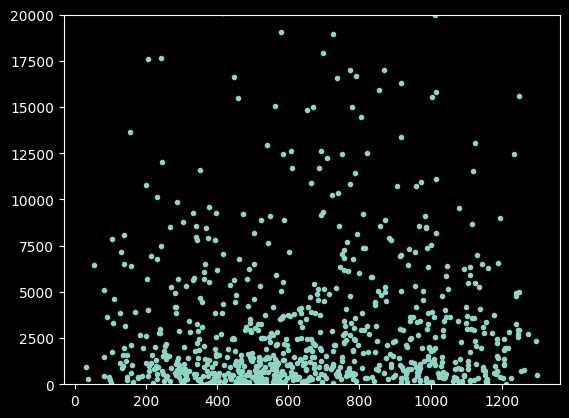

In [80]:
plt.plot(dist0,msd2,'.')
plt.ylim(0,20000)

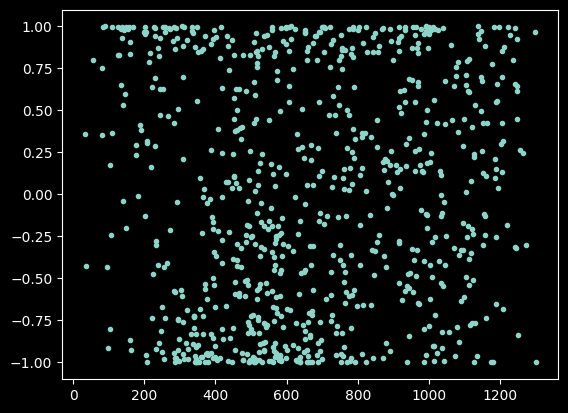

In [81]:
plt.plot(dist0,align,'.')


## Mean-square displacement

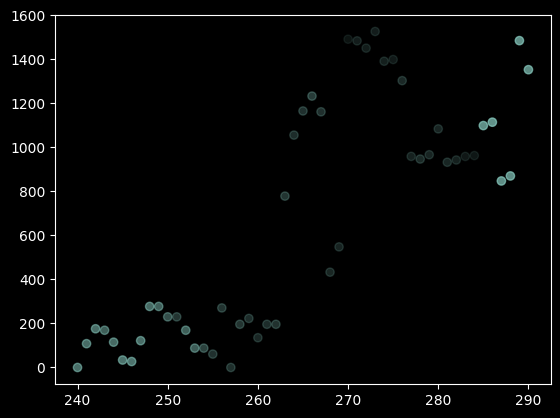

In [82]:
def SD(traj):
    frames = traj[0]
    pos = traj[1]
    T = len(frames)
    X0 = pos[0,:]
    return ((X0 - pos[:,:])**2).sum(1)

%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(trajs[n][0],SD(trajs[n]),alpha=log_intensity)

IndexError: index 99 is out of bounds for axis 0 with size 60

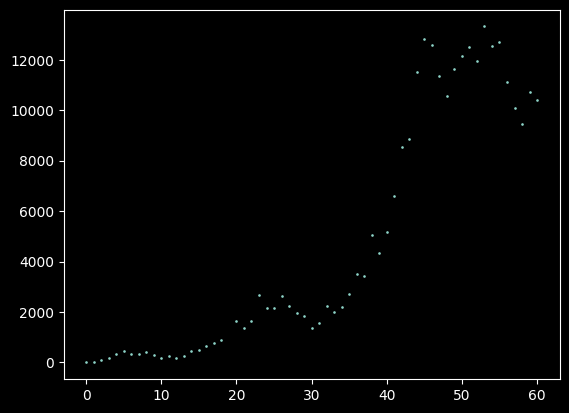

In [83]:
%matplotlib inline

fig, ax = plt.subplots()
sd_f = []
for traj in trajs[0:]:
    ax.scatter(traj[0],SD(traj),s=0.8)
    sd_f.append(SD(traj)[99])
# ax.plot(sd_f,'.')

## Speed and directions

In [ ]:
def speed_dir(traj,dt):
    frames = traj[0]
    pos = traj[1]
    speed = []
    direct = []
    t = 0 
    while t+dt<len(frames): 
        speed.append(np.linalg.norm(pos[t+dt,:-1] - pos[t,:-1])/(frames[t+dt] - frames[t]))
        direct.append(np.arctan2(pos[t+dt,1] - pos[t,1],pos[t+dt,0] - pos[t,0]))
        t += dt
    return np.array(speed), np.array(direct)

In [ ]:
speed, direct = speed_dir(trajs[0],5)

In [ ]:
%matplotlib inline
plt.plot(speed)

In [ ]:
%matplotlib inline
plt.scatter(np.cos(direct),np.sin(direct))


In [ ]:
%matplotlib inline
kappa = []
leng = []
for traj in trajs:
    speed, direct = speed_dir(traj,5)
    # print(len(direct))
    leng.append(len(direct))
    kappa.append(np.linalg.norm(np.mean(np.c_[np.cos(direct),np.sin(direct)],axis=0)))
    
plt.plot(kappa,'.')
plt.ylim(0,1)
# plt.plot(leng,kappa,'.')